# Information
This Jupyter Notebook file contains the code necessary to compute the standard errors for the Spectral Targeting Estimator of the EigenGARCH model as presented in Hetland (2020).  
 
This file contain the code to estimate the model and include four specific functions: 
* 'asymp_var'           - computes the asymptotic variance and standard errors of the ith equation  
* 'finite_k_mom'        - is used to check the moment requirement for finite fourth order moments. Implemented assuming Gaussian innovations
* 'loglikelihood'       - the i'th log-likelihood function
* 'loglikelihood_cont'  - the vector of log-likelihood contributions.

These functions are in the bottom 4 cells, make sure to execute these before running the rest of the code. Also, the functions make extensive use of global variables, so they may need to be modified if you want to use them for your own projects



---

**Author:** Simon Hetland  
**e-mail:** <bhp240@ku.dk>  
16 June 2020  

### Housekeeping

In [1]:
%reset
import pandas as pd                    # read data
import numpy as np                     # scientific computing
import scipy.optimize as opt           # optimization package
from matplotlib import pyplot as plt   # Plotting
from numdifftools import Gradient, Jacobian, Hessian #function to compute jacobian and hessian
import scipy.stats as scs              # contains test for e.g. normality
import yfinance as yf                  # download data from Yahoo finance
plt.style.use('fivethirtyeight')
import sys
np.set_printoptions(suppress = False)   #disable scientific notation
import seaborn as sns
import statsmodels.tools.numdiff as stats


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


### Load data and specify options

In [2]:
A_type =  'full'             #diagonal or full
var_est = 'targeting'        #estimated or targeting
likelihood_cont_output='all'
GARCH = 1
p = 2

#Load data and rearrange slightly
data = pd.read_excel('../SP500_sectors.xlsx')
data.index = data['Dates']
data = data.drop(columns=data.columns[0])

sectors = ['S5UTIL', 'S5TELS', 'S5RLST', 'S5MATR', 'S5INFT', 'S5INDU', 'S5HLTH', 'S5FINL', 'S5ENRS', 'S5CONS', 'S5COND']
T_start = np.size(data,0)-252*8-1
T_end   = np.size(data,0)
df = data.iloc[T_start:T_end]
df = df[df.columns[0:p]]

x = np.array(df) #from dataframe to matrix
x = x.T          #transpose to have p x T matrix
T = df.shape[0]

npar = 0 #Number of GARCH parameters (not including first step estimation of unconditional covariance matrix)
if A_type=='full':       npar = npar+p
else:                    npar = npar+1
if GARCH==1:             npar = npar+1 
if var_est=='estimated': npar = npar+1

    

### Summary statistics


Summary statistics
Correlations
          S5UTIL    S5TELS
S5UTIL  1.000000  0.521733
S5TELS  0.521733  1.000000

Average return and volatility (percent p.a.), skew and kurtosis
            Mean     St.dev      Skew  Kurtosis
S5UTIL  6.590748  14.137363 -0.409382  5.374582
S5TELS  3.810809  15.106656 -0.239987  5.084597


C:\Users\bhp240\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


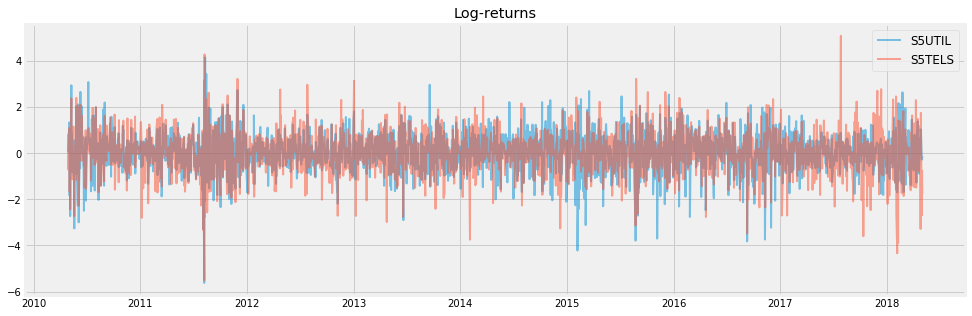

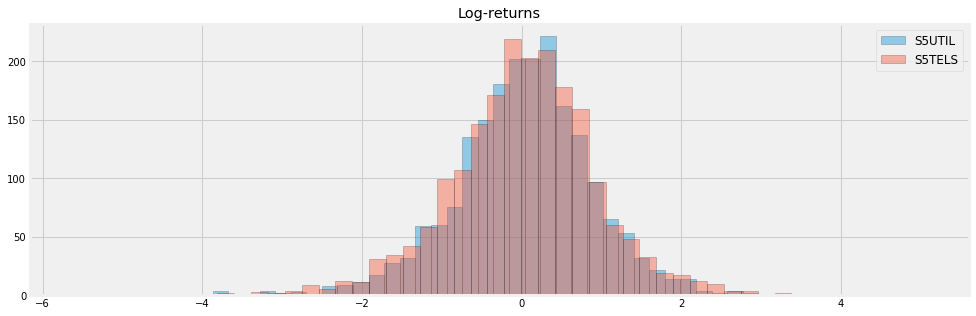

In [3]:
print('\nSummary statistics')
print('Correlations')
print(df.corr())
print("\nAverage return and volatility (percent p.a.), skew and kurtosis")
print(pd.concat([252*df.mean(), np.sqrt(252)*df.std(), df.skew(), df.kurtosis()+3], axis=1, keys=['Mean','St.dev','Skew','Kurtosis']))

#Plot returns
plt.figure(figsize=(15, 5))
for c in df.columns.values:
    plt.plot(df.index, df[c], lw=2, alpha=0.5,label=c)
plt.legend(loc='best', fontsize=12)
plt.title('Log-returns')
plt.show()

##Plot autocorrelation function of absolute
#for c in np.arange(0,p):
#    plt.acorr(np.squeeze(np.asarray(np.abs(x[c,:]))), maxlags=10)
#    plt.show()

#Plot histogram
plt.figure(figsize=(15, 5))
for c in df.columns.values:
    sns.distplot(df[c].values, label=c, hist=True, kde=False, hist_kws={'edgecolor':'black'});
plt.legend(loc='best', fontsize=12)
plt.title('Log-returns')
plt.show()    


### 1.step estimator  - unconditional eigenvalues and -vectors

In [766]:
#Estimate unconditional covariance matrix
H_uncon = np.cov(x)

#Spectral decomposition
[l,V]=np.linalg.eigh(H_uncon)

#Sort eigenvalues and vectors (largest to smallest)
idx = l.argsort()[::-1]   
#l = np.matrix([l[idx]]).T
l = l[idx]
#V = np.matrix(V[:,idx])
V = V[:,idx]

#Identifying normalization
for i in range(0,p):
    if V[i,i]<0:
        V[:,i]=V[:,i]*(-1)        
        
#First step estimator
theta_step1 = np.concatenate((l, (V.flatten()).T),axis=0)

#Construct rotated returns
y = np.dot(np.transpose(V),x)

#Summary statistics wrt. 1. step estimator
l_per = l/np.sum(l)

print('\nEigenvalues of unconditional covariance matrix are (percent)')
print(l_per*100)


Eigenvalues of unconditional covariance matrix are (percent)
[76.23911758 23.76088242]


### 2. step estimator - univariate (augmented) GARCH

In [798]:
#Matrices to contain estimated variances and residuals
lt        = np.zeros((p,T)) 
z_hat     = np.zeros((p,T)) 
L         = np.zeros((p, 3))
theta_i   = np.zeros((p,npar))

se_est =0
#Matrices to contain estimated parameters
if A_type=='diagonal':        A = np.zeros((p,1))
else:                         A = np.zeros((p,p))
B = np.zeros((p,1))
W = np.zeros((p,1))

for j in range(0,p):
#for j in range(0,1):
    #Initial values for estimation
    if A_type=='diagonal': theta0 = np.array([0.05, 0.75, 0.8])      #[a, b, w]
    elif A_type=='full':   
        theta0 = np.concatenate(([np.ones((1,p))*0.02],np.array([0.7, 0.7])), axis = None)
        theta0[j] = 0.05                                                              #[a1, ..., ap, b, w]
    if var_est=='targeting': theta0 = theta0[0:np.size(theta0,0)-1]  #remove w
    if GARCH==0: theta0=theta0[0:np.size(theta0,0)-1]                #renove b
        
    #Evaluate log-likelihood function to check if everything works        
    likelihood_cont_output = 'lik'
    ll=likelihood(theta0)
  
    #Numerical optimization of log-likelihood function        
    lb = np.ones(np.shape(theta0))*0
    ub = np.ones(np.shape(theta0))
    bnds=opt.Bounds(lb, ub)
    #MLE = opt.minimize(likelihood, theta0, method='BFGS', options={'disp': True} )
    MLE = opt.minimize(likelihood, theta0, method='SLSQP',  bounds=bnds, options={'disp': True} )
    
    #Save parameters
    theta_j = MLE.x
    #theta_j = theta0
    
    #Eigenvalues of hessian (for SOC)
    Hessian_ = Hessian(likelihood, step=1e-7)
    Hess = Hessian_(theta_j)
    if np.isnan(sum(sum(Hess)))==False and np.isinf(sum(sum(Hess)))==False:
        hess_eig, _ = np.linalg.eig(Hess)
        hess_eig = np.min(hess_eig)>0
    else:
        hess_eig = float('nan')

    #Vector containing log-likelihood value, foc and soc (should be 0 and 1 respectively)
    L[j,:] = [-T*MLE.fun, np.max(MLE.jac), hess_eig] 

    #Retrieve estimated variance and residual
    likelihood_cont_output='all'
    _, lt[j,:], z_hat[j,:] = likelihood_cont(theta_j)
    
    #Save parameters in matrices
    tal = 0
    if A_type== 'diagonal':        
        A[j]   = theta_j[tal]
        tal    = tal+1
    else:                                
        A[j,:] = theta_j[tal:tal+p]
        tal    = tal+p    
    if GARCH == 1:
        B[j]   = theta_j[tal]
        tal    = tal+1
    else:  
        B[j]   = 0                         
    if var_est=='estimated':           
        W[j]   = theta_j[tal]
        tal    = tal+1
    else:
        if A_type=='diagonal':  
            W[j] = (1-B[j])*l[j]-A[j]*l[j]
        else:                       
            W[j] = (1-B[j])*l[j]-np.dot(A[j,:],l)
    
    #Save estimated parameters
    theta_i[j,:] = theta_j
    
#Second step estimator
theta_step2 = np.concatenate((A.flatten(), B.flatten()), axis=0)

#Joint parameter vector
theta =np.concatenate((theta_step1,theta_step2),axis=0)

print('Univariate log-likelihoods, FOC and SOC:\n', L)    
print('\nEstimated parameters:')
print('W\n', np.round(W,decimals=3))
print('A\n', np.round(A,decimals=3))
print('B\n', np.round(B,decimals=3))

C:\Users\bhp240\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in log
C:\Users\bhp240\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in sqrt


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4979146536230539
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9340569452507133
            Iterations: 19
            Function evaluations: 107
            Gradient evaluations: 19
Univariate log-likelihoods, FOC and SOC:
 [[-3.02129386e+03  6.13301992e-04  1.00000000e+00]
 [-1.88399286e+03  1.44931823e-02  1.00000000e+00]]

Estimated parameters:
W
 [[0.112]
 [0.003]]
A
 [[0.121 0.021]
 [0.    0.025]]
B
 [[0.786]
 [0.968]]


### Conditional covariance matrices and joint log-likelihood

In [799]:
#Compute conditional covariance matrices and joint log-likelihood
#Joint loglikelihood
L_joint = (np.sum(L,0))[0]
print('Joint log-likelihood value:\n', L_joint)

#Estimated covariances, volatilitites and correlations
H = np.zeros((p,p,T))
vol = np.zeros((p,T))
corr = np.zeros((np.int(p*(p-1)/2),T))
for t in np.arange(1,T):
    #Construct covariance matrices
    H[:,:,t] = V @ np.diag(lt[:,t]) @ V.T
    #Extract vector of correlations
    tmp = np.diag(1./np.sqrt(np.diag(H[:,:,t]))) @ H[:,:,t] @ np.diag(1./np.sqrt(np.diag(H[:,:,t])))
    tmp = np.tril(tmp)-np.diag(np.diag(tmp))
    tmp=tmp[tmp != 0]    
    tmp=tmp.flatten()
    corr[:,t] = tmp
    #Volatilities
    vol[:,t] = np.transpose(np.sqrt(np.diag(H[:,:,t])))
    
#Put in dataframe for easy graphs
df_lt = pd.DataFrame(np.transpose(lt), columns=['lambda_' + str(i) for i in range(1, len(lt)+1)], index = df.index)
df_res = pd.DataFrame(np.transpose(z_hat), columns=[i + '_res'for i in df.columns.values], index = df.index)    
df_vol = pd.DataFrame(np.transpose(vol), columns=[i + '_vol'for i in df.columns.values], index = df.index)    
df_corr = pd.DataFrame(np.transpose(corr), columns=['corr_' + str(i) for i in range(1, len(corr)+1)], index = df.index)    

Joint log-likelihood value:
 -4905.286714928388


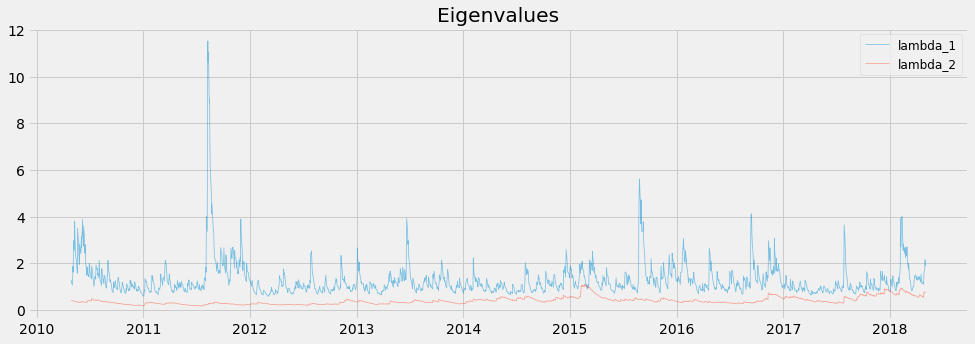

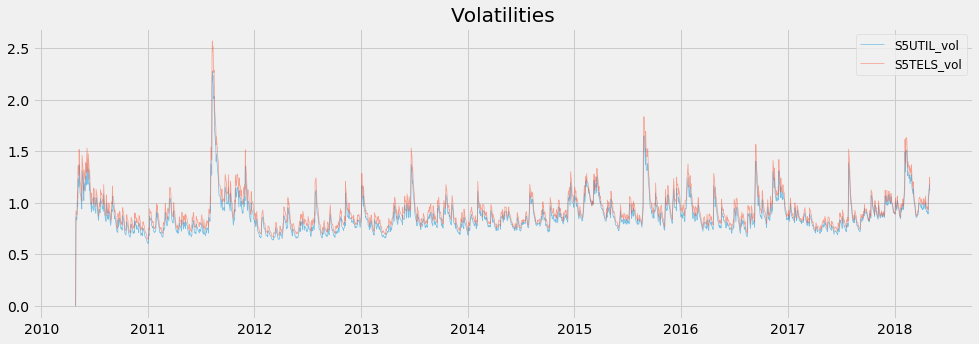

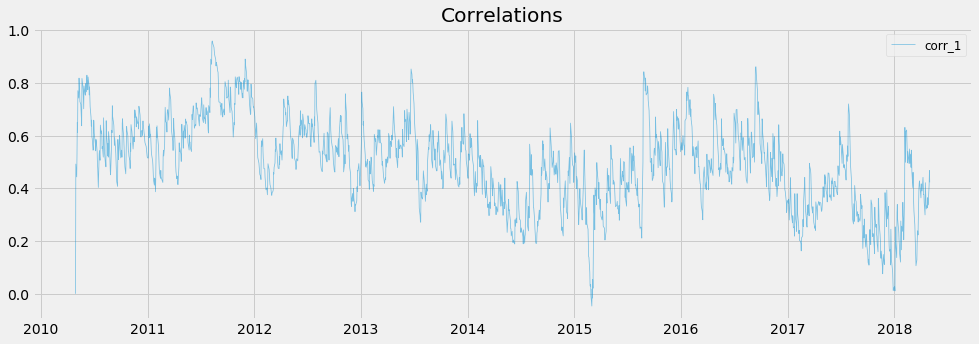

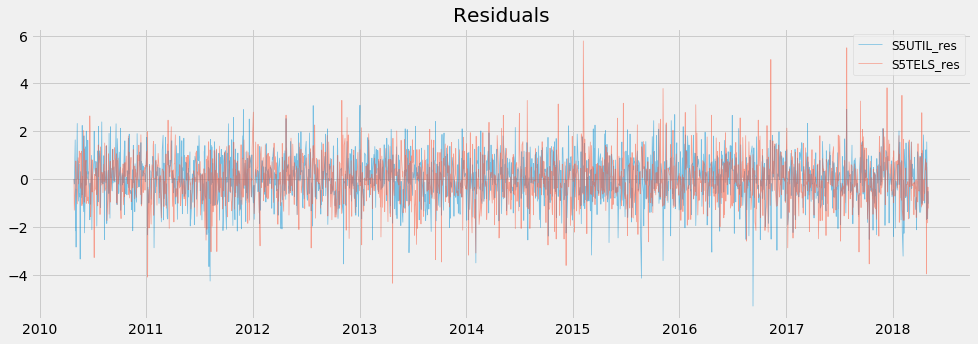

Residual diagonstics:
                Mean    St.dev      Skew  Kurtosis
S5UTIL_res  0.019162  0.998394 -0.364298  3.946127
S5TELS_res -0.016470  1.009437  0.111401  5.095370


In [800]:
#Plot estimated eigenvalues
plt.figure(figsize=(15, 5))
for c in df_lt.columns.values:
    plt.plot(df_lt.index, df_lt[c], lw=0.75, alpha=0.5,label=c)
plt.legend(loc='best', fontsize=12)
plt.title('Eigenvalues')
plt.show()

#Plot estimated volatilities
plt.figure(figsize=(15, 5))
for c in df_vol.columns.values:
    plt.plot(df_vol.index, df_vol[c], lw=0.75, alpha=0.5,label=c)
plt.legend(loc='best', fontsize=12)
plt.title('Volatilities')
plt.show()

#Plot estimated correlations
plt.figure(figsize=(15, 5))
for c in df_corr.columns.values:
    plt.plot(df_corr.index, df_corr[c], lw=0.75, alpha=0.5,label=c)
plt.legend(loc='best', fontsize=12)
plt.title('Correlations')
plt.show()

#Plot residuals
plt.figure(figsize=(15, 5))
for c in df_res.columns.values:
    plt.plot(df_res.index, df_res[c], lw=0.75, alpha=0.5,label=c)
plt.legend(loc='best', fontsize=12)
plt.title('Residuals')
plt.show()

print('Residual diagonstics:')
print(pd.concat([df_res.mean(), df_res.std(), df_res.skew(), df_res.kurtosis()+3], axis=1, keys=['Mean','St.dev','Skew','Kurtosis']))    
    

### Existence of moments

In [1010]:
# Check existence of fourth order moment
k=4
mom_k, mom_k_ci = finite_k_mom(k)
print(mom_k,mom_k_ci) #mom_k and mom_k_ci should be <1 for k=4


0.9879930930510765


### Inference

In [801]:
#Inference
se_i = np.zeros((p,npar))
theta_SVTE = 0
se_SVTE=0

for j in np.arange(0,p): #Loop for the p univariate equations
    se_est=1
    likelihood_cont_output = 'lik'        
    theta_j =  np.concatenate((theta_step1,theta_i[j]),axis=0)
    se_j = asymp_var(theta_j)
    se_i[j,:] = se_j[p**2+p:] #S.e.s' for the (G)ARCH parameters for the j'th equation
    
se_cov = np.array(se_j[0:p**2+p]) #S.e.'s for the eigenvalues and vectors

se_est=0
likelihood_cont_output = 'all'    


### Print output

In [802]:
# Print output nicely
step1_names = ['l_'+str(i) for i in np.arange(1,p+1)]
for i in np.arange(0,p):
    for j in np.arange(0,p):
        step1_names = step1_names + ['V_'+str(i+1)+str(j+1)]

print('\nStep 1:')
print(pd.DataFrame(np.array([theta_step1, se_cov, np.divide(theta_step1,se_cov)]).T, columns=['Estimates', 'standard errors', 't-stat'], index=step1_names))
for j in np.arange(0,p):
    if A_type =='full':
        step2_names = ['a_'+str(j+1)+str(i) for i in np.arange(1,p+1)]+ ['b_'+str(j+1)]
    elif A_type =='diagonal':
        step2_names = ['a_'+str(j+1), 'b_'+str(j+1)]    
    print('\nStep 2, equation '+ str(j+1) + ':')
    print(pd.DataFrame(np.array([theta_i[j,:], se_i[j,:], np.divide(theta_i[j,:],se_i[j,:])]).T, columns=['Estimates', 'standard errors', 't-stat'], index=step2_names))



Step 1:
      Estimates  standard errors     t-stat
l_1    1.295085         0.021127  61.300800
l_2    0.403630         0.060396   6.683037
V_11   0.660992         0.017023  38.829559
V_12  -0.750393         0.014995 -50.043613
V_21   0.750393         0.014995  50.043613
V_22   0.660992         0.017023  38.829559

Step 2, equation 1:
      Estimates  standard errors     t-stat
a_11   0.120791         0.031911   3.785208
a_12   0.020871         0.027331   0.763623
b_1    0.786238         0.065908  11.929388

Step 2, equation 2:
         Estimates  standard errors        t-stat
a_21  9.829691e-21         0.000643  1.529424e-17
a_22  2.528712e-02         0.026919  9.393628e-01
b_2   9.683173e-01         0.038693  2.502551e+01


### Functions


In [803]:
def asymp_var(theta):
    #Eigenvalues, eigenvectors and uncond. covariance matrix
    l = theta[0:p]
    V = np.reshape(theta[p:p+p**2],(p,p))
    H = V@np.diagflat(l)@V.T
    
    #D = np.matrix(np.zeros((p,p**2)))
    D = np.zeros((p,p**2))
    for i in range(0,p):
        D[i,i+i*p]=1
 
    #Jacobian of liglikelihood contributions
    Jac_ = Jacobian(likelihood_cont, step=1e-8, order=2, method='forward')    
    Jac = (Jac_(theta))    
    score = Jac[:,p**2+p:].T    
        
    npar = p+p**2    #Parameters in l and V
    if GARCH==1:     #+ GARCH parameters of equation i
        npar=npar+1
    if A_type=='full':
        npar=npar+p
    else:
        npar=npar+1

    Omega = np.zeros((npar,npar))
    omega = np.zeros((npar,1))
    
    #Loop to compute Omega^(i)
    for t in np.arange(0,T):    
        tmp = np.array([x[:,t]]).T
        tmp = tmp@tmp.T        
        tmp= np.array([tmp.flatten()]).T-np.array([H.flatten()]).T
        
        #Fill in eigenvalues
        omega[0:p] = D@np.kron(V,V)@tmp
        
        #Fill in eigenvectors
        for i in np.arange(0,p):
            omega[p+i*p:p+i*p+p] = np.kron(V[:,i].T,np.linalg.pinv(np.multiply(l[i],np.eye(p))-H))@tmp            
        
        #Fill in score of log-likelihood function
        omega[p+i*p+p:] = np.array([score[:,t]]).T
        
        #Compute Omega
        Omega = Omega + omega*omega.T

    #Eq. (4.3)    
    Omega = Omega/T    
    
    #Compute numerical Hessian, 1/T sum d^2 l / dpdp'
    Hess = stats.approx_hess3(theta_j, likelihood)    
    
    #Construct J and K matrices
    J_inv = np.linalg.inv(Hess[p**2+p:,p**2+p:])
    K = Hess[p**2+p:,0:p**2+p]

    #Construct Sigma
    Sigma = np.concatenate(
            (np.concatenate((np.identity(p**2+p),np.zeros((p**2+p,npar-p**2-p))),axis=1)
            ,
            np.concatenate((-J_inv @ K, -J_inv),axis=1)), axis=0         
            )


    #Compute asymptotc variance-covariance matrix
    cov_sample = (Sigma @ Omega @ Sigma.T)/T

    se_sample = np.sqrt(np.diag(cov_sample))

    return se_sample



In [1012]:
def finite_k_mom(k):
    k=int(k/2)
    if A_type =='diagonal':
        A_loc = np.diagflat(A)
    else:
        A_loc = A
        
    B_loc = np.diagflat(B)
    if k==1:
        eig, _     = np.linalg.eig(A+np.diagflat(B))
        eig_H_k    = np.max(eig)
        eig_H_se = 0;
    else:
        N = 399
        #l = np.zeros((p,T,1))
        H = np.zeros((p,p,T))
        H_k = 0
        H_k_vec = np.zeros((int(p**k**2), N,1))
        for n in range(0,N):
            for t in range(1,T):        
                z        = np.array([np.random.normal(0,1,p)]).T
                #l[:,t]   = W + A_loc@np.array([y[:,0]]).T+B_loc@np.array([l[:,t-1]]).T
                H[:,:,t] =  A_loc@np.diagflat(z*z)+B_loc
                tmp = np.kron(H[:,:,t],H[:,:,t])
                for i in range(2,k):
                    tmp = np.kron(tmp, H[:,:,t])
                H_k = H_k+tmp
            
            H_k          = 1/T*H_k  
            H_k_vec[:,n] = np.array([H_k.flatten()]).T          
        
        H_k_5    = np.reshape(np.quantile(H_k_vec, 0.05, axis=1),(p**k,p**k))
        H_k_95   = np.reshape(np.quantile(H_k_vec, 0.95, axis=1),(p**k,p**k))
        H_k_mean = np.reshape(np.mean(H_k_vec, axis=1),(p**k,p**k))
                
        tmp0, _ = np.linalg.eig(H_k)            
        tmp1, _ = np.linalg.eig(H_k_5)    
        tmp2, _ = np.linalg.eig(H_k_95)
        eig_H_k  = max(tmp0)
        eig_H_se = [max(tmp1), max(tmp2)]
        
        
    return eig_H_k, eig_H_se


In [1017]:
def likelihood(param):
    '''Loglikelihood function for GARCH(1,1)'''
    lik = likelihood_cont(param)
    
    return -np.mean(lik) #Return mean of negative likelihood

In [1018]:
def likelihood_cont(param):    
    '''Loglikelihood contributions for GARCH(1,1)'''
    T = np.size(x,1) # nr of observations
    p = np.size(x,0)
    tal=0
    
    if se_est==1:
        l = param[0:p]
        V = np.reshape(param[p:p+p**2],(p,p))
        H = V*np.diagflat(l)*V.T
        tal = tal+p**2+p
    else:
        #Estimate unconditional covariance matrix (for estimation)
        H = np.cov(x)
        
        #Spectral decomposition
        [l,V]=np.linalg.eig(H)
        
        #Sort eigenvalues and vectors (largest to smallest)
        idx = l.argsort()[::-1]   
        l = np.array([l[idx]]).T
        V = np.array(V[:,idx])
                
        #Identifying normalization
        for i in range(0,p):
            if V[i,i]<0:
                V[:,i]=V[:,i]*(-1)                            
            
    #Rotated returns    
    y = np.dot(np.transpose(V),x)
    
    # define parameters    
    if A_type == 'diagonal':
        a =  np.zeros((1,p))
        a[0,j] = np.array((param[tal]))
        tal  = tal+1
    elif A_type == 'full':
        a = np.array([param[tal:tal+p]])    
        tal = tal + p
    if GARCH==0:
        b = np.array(0)
    elif GARCH==1:
        b = np.array(param[tal])
        tal = tal + 1        
    if var_est == 'estimated':
        w = np.array(param[tal])
    elif var_est =='targeting':        
        w = np.array((1-b)*l[j]-np.dot(a,l))
                
    # array to contain variances and loglikelihood contributions
    h      = np.zeros(T, dtype=object)
    lik    = np.zeros(T, dtype=object)
    res    = np.zeros(T, dtype=object)
    
    h[0] = l[j] 
    
    for t in np.arange(1,T):        
        h[t]   = np.array(w+np.dot(a,np.square(y[:,t-1]))+b*h[t-1])
        lik[t] = np.array(-0.5*(np.log(2*np.pi)+np.log(h[t])+np.square(y[j,t])/h[t]))
        res[t] = np.array(y[j,t]/np.sqrt(h[t]))
                
    if likelihood_cont_output == 'lik':
        return lik
    else:
        return lik, h, res